In [1]:
import numpy as np
import pandas as pd
import nltk
import os
import warnings
import re
from google_play_scraper import Sort, reviews_all
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from summa import keywords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Set up environment
os.chdir('C:\\Users\\aakan\\Downloads')
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aakan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aakan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aakan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
# Fetch reviews from Google Play Store
reviews = reviews_all(
    'com.yolo.love.chat.meet.dating',
    lang='en'
)
print(reviews)

[{'reviewId': '28c49a1e-7144-42ee-ab7e-0431b1083e65', 'userName': 'Jahid arab', 'userImage': 'https://play-lh.googleusercontent.com/a-/ALV-UjU6SQEa4ukrr9siWSNhrksVsodxgXewM7YOrrXrtyAT2OyfMgQ', 'content': 'Op', 'score': 5, 'thumbsUpCount': 0, 'reviewCreatedVersion': '2.1.1', 'at': datetime.datetime(2024, 7, 25, 15, 49, 16), 'replyContent': None, 'repliedAt': None, 'appVersion': '2.1.1'}, {'reviewId': 'b4b352b2-8d3e-4d01-976b-76f559d8000f', 'userName': 'Rakesh Kumar', 'userImage': 'https://play-lh.googleusercontent.com/a/ACg8ocKZIQNRi_W02Lmycdyl-SQYpkM4dxXaYhGePvSgwvW89xUGJQ=mo', 'content': 'Best aap', 'score': 5, 'thumbsUpCount': 0, 'reviewCreatedVersion': None, 'at': datetime.datetime(2024, 7, 23, 19, 16, 30), 'replyContent': None, 'repliedAt': None, 'appVersion': None}, {'reviewId': '9def39ad-b3f1-41f3-90f5-9d64d7e5fe2e', 'userName': 'Adnan Shaikh', 'userImage': 'https://play-lh.googleusercontent.com/a-/ALV-UjU7qnqAB9g9-PSjVX44PbU0-_-y7TFYq_XMPJcUMbkHBbLwtt90', 'content': 'Butiful app

In [7]:
# Extract review texts and ratings
review_texts = [review['content'] for review in reviews]
ratings = [review['score'] for review in reviews]

In [8]:
# Create DataFrame
review_df = pd.DataFrame({'Review': review_texts, 'Rating': ratings})

# Filter for 1 and 2-star reviews
review_df = review_df[review_df['Rating'].isin([1, 2])].reset_index(drop=True)
print(review_df)

                                               Review  Rating
0                                             Bad app       1
1                                        Too much ads       1
2                             Unusable - constant ads       1
3                                            Nice app       1
4                                                Good       1
5   Nothing but ads. Can't change password, ads ad...       1
6                                         To many ads       1
7          One of waste of space & time I'd ever seen       1
8                          I didn't needed a paid app       1
9                     Fake girls id this app very bad       1
10                                            No good       1
11  My 14 year old son signed up for this site wit...       1
12  Such a rubbish app. a lot of bots will come to...       1
13                                               SCAM       1
14                                               Nice       2
15      

In [9]:
# Basic preprocessing: removing numbers and emojis
def remove_nonalphabets(dataset):
    return [re.sub(r'[^a-z ]', '', text.lower()) for text in dataset]

review_df['Cleaned_Review'] = remove_nonalphabets(review_df['Review'])

# Perform lemmatization and remove stopwords
def lem_stopwords(dataset):
    lemmatizer = WordNetLemmatizer()
    sw_list = stopwords.words('english')
    cleaned_dataset = []
    for text in dataset:
        words = nltk.word_tokenize(text)
        words = [lemmatizer.lemmatize(word) for word in words if word not in sw_list]
        cleaned_dataset.append(' '.join(words))
    return cleaned_dataset

review_df['Processed_Review'] = lem_stopwords(review_df['Cleaned_Review'])
print(review_df['Processed_Review'])

0                                               bad app
1                                               much ad
2                                  unusable constant ad
3                                              nice app
4                                                  good
5              nothing ad cant change password ad ad ad
6                                               many ad
7                     one waste space time id ever seen
8                                 didnt needed paid app
9                                  fake girl id app bad
10                                                 good
11             year old son signed site without knowing
12    rubbish app lot bot come chat make fool using ...
13                                                 scam
14                                                 nice
15                                           verryvnice
16                                              many ad
17      fake fruad app single real dont usr wast

In [10]:
# Extract keywords
def extract_keywords(dataset):
    keywords_list = []
    for text in dataset:
        key = keywords.keywords(text, ratio=0.9, scores=False)
        keywords_list.append(', '.join(key.split('\n')))
    return keywords_list

review_df['Keywords'] = extract_keywords(review_df['Processed_Review'])
print(review_df['Keywords'])


0                                                   bad
1                                                      
2                                                    ad
3                                                  nice
4                                                      
5                                          password, ad
6                                                      
7                                         space time id
8                                                   app
9                                                   bad
10                                                     
11                                  old son signed site
12             rubbish app lot bot come chat make, coin
13                                                     
14                                                     
15                                                     
16                                                     
17            fake fruad app single real dont us

In [11]:
# Cluster reviews using KMeans
def cluster_reviews(dataset, num_clusters=5):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(dataset)
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(tfidf_matrix)
    return kmeans.labels_, kmeans

cluster_labels, kmeans_model = cluster_reviews(review_df['Processed_Review'])
review_df['Cluster'] = cluster_labels
print(review_df)

                                               Review  Rating  \
0                                             Bad app       1   
1                                        Too much ads       1   
2                             Unusable - constant ads       1   
3                                            Nice app       1   
4                                                Good       1   
5   Nothing but ads. Can't change password, ads ad...       1   
6                                         To many ads       1   
7          One of waste of space & time I'd ever seen       1   
8                          I didn't needed a paid app       1   
9                     Fake girls id this app very bad       1   
10                                            No good       1   
11  My 14 year old son signed up for this site wit...       1   
12  Such a rubbish app. a lot of bots will come to...       1   
13                                               SCAM       1   
14                       

In [12]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(TfidfVectorizer().fit_transform(review_df['Processed_Review']).toarray())
review_df['PCA1'] = reduced_features[:, 0]
review_df['PCA2'] = reduced_features[:, 1]

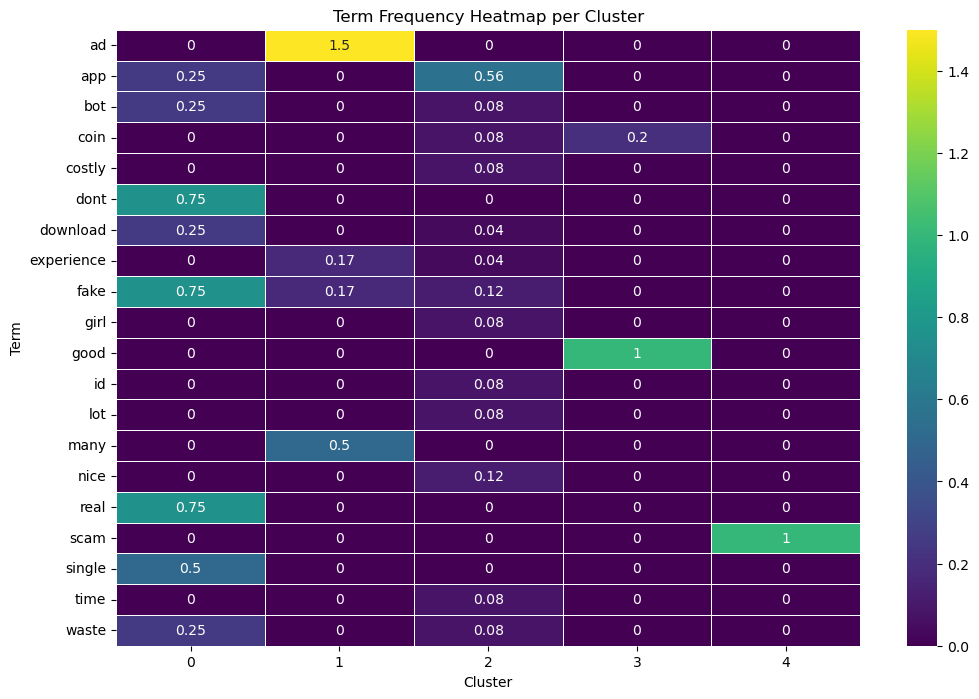

In [16]:
#This heatmap will visualize the frequency of key terms across different clusters.

from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer to count the frequency of terms
vectorizer = CountVectorizer(max_features=20)
X_counts = vectorizer.fit_transform(review_df['Processed_Review'])
term_frequency_df = pd.DataFrame(X_counts.toarray(), columns=vectorizer.get_feature_names_out())

# Add cluster labels to the DataFrame
term_frequency_df['Cluster'] = review_df['Cluster']

# Compute the mean frequency of each term per cluster
mean_term_frequency = term_frequency_df.groupby('Cluster').mean()

# Generate a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(mean_term_frequency.T, annot=True, cmap='viridis', linewidths=0.5)
plt.title('Term Frequency Heatmap per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Term')
plt.show()


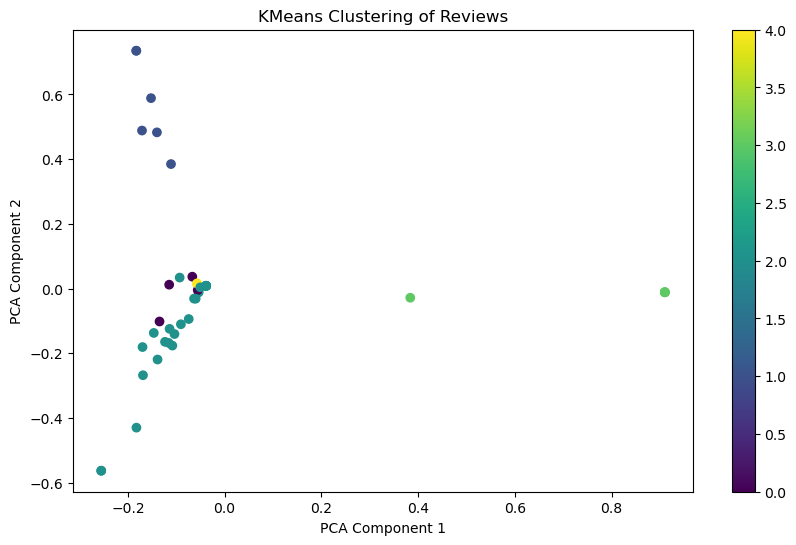

In [13]:
# Visualize clusters
plt.figure(figsize=(10, 6))
plt.scatter(review_df['PCA1'], review_df['PCA2'], c=review_df['Cluster'], cmap='viridis')
plt.title('KMeans Clustering of Reviews')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

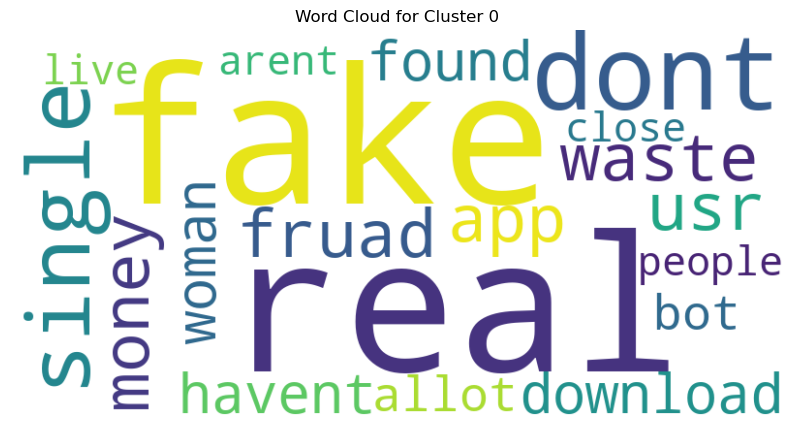

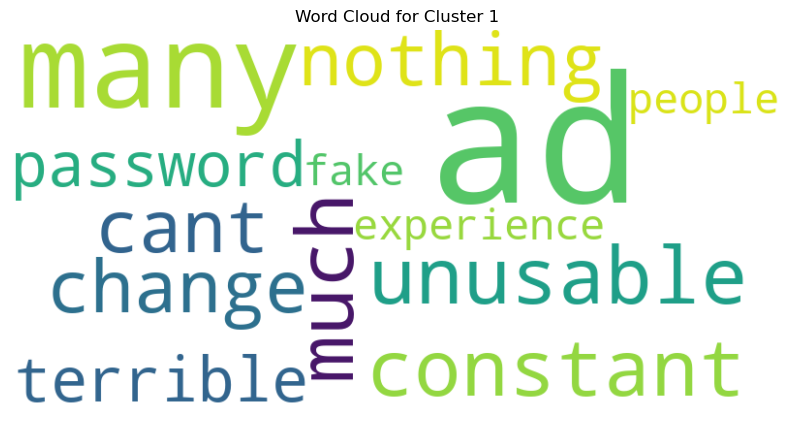

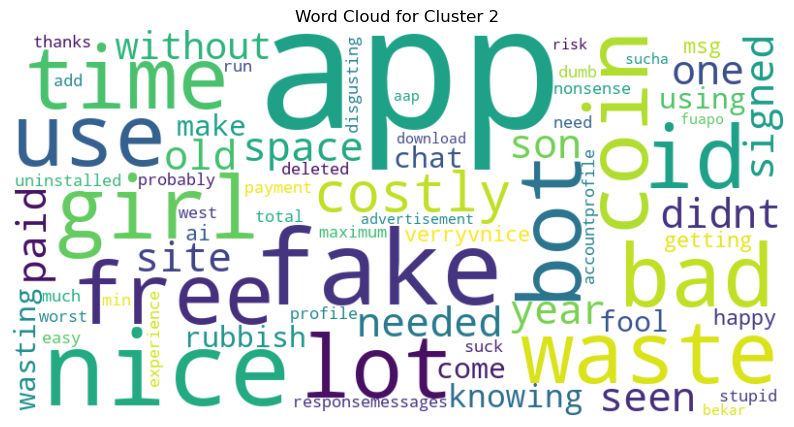

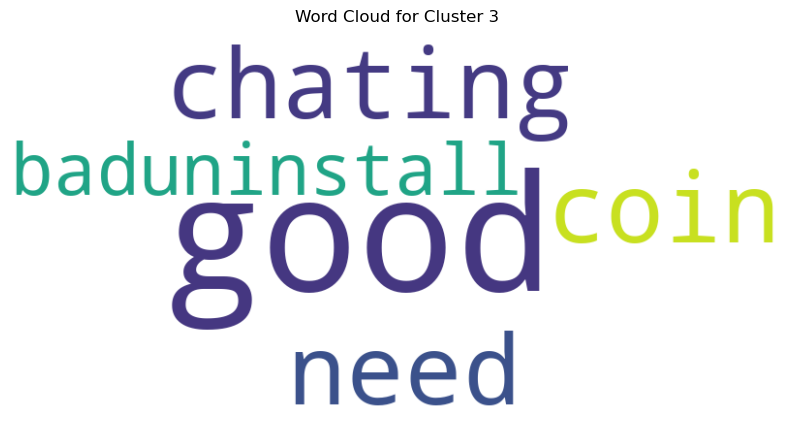

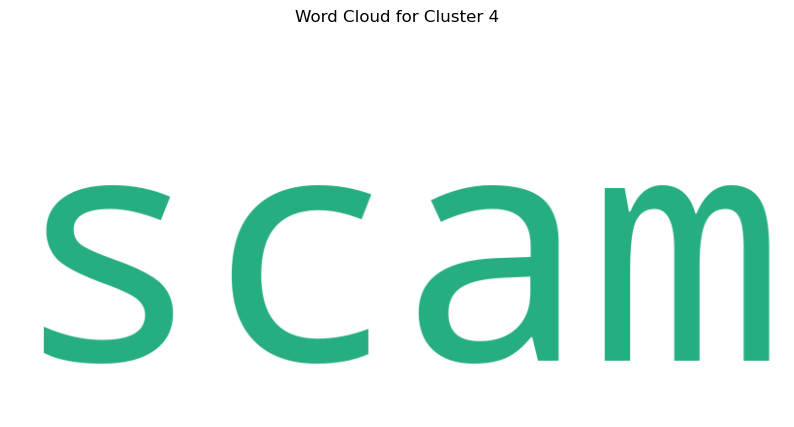

In [14]:
# Generate word clouds for each cluster
for cluster_num in range(kmeans_model.n_clusters):
    cluster_text = ' '.join(review_df[review_df['Cluster'] == cluster_num]['Processed_Review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_num}')
    plt.show()

In [ ]:
# Save results to an Excel file
review_df.to_excel('Output_Data_Enriched.xlsx', index=False)